<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/Laminao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

em0 = 3.23; Lm0 = 11.7; Cm0 = 48.47
em1 = 3.08; Lm1 = 11.65; Cm1 = Cm0*(em0*Lm0)/(em1*Lm1)
em2 = 2.97; Lm2 = 11.68; Cm2 = Cm1*(em1*Lm1)/(em2*Lm2)
em3 = 2.82; Lm3 = 11.85; Cm3 = Cm2*(em2*Lm2)/(em3*Lm3)

dados = {'Inicial': {'e': em0, 'L': Lm0, 'c': Cm0},
         'Passe 1': {'e': em1, 'L': Lm1, 'c': Cm1},
         'Passe 2': {'e': em2, 'L': Lm2, 'c': Cm2},
         'Passe 3': {'e': em3, 'L': Lm3, 'c': Cm3}}

R_rolo = 35.0 #raio em mm
mu = 0.085 #atrito
sigma_0 = 130.0 #tensao de escoamento do aluminio

K = 500 #Coeficiente de resistência em MPa
n = 0.25 #coeficiente de encruamento

  Etapa  Volume (mm³)  Desvio Volumétrico (%)  Redução Espessura (%)  ε_total  Pressão de Laminação (MPa)  Força (kN)  Potência (W)
Passe 1       1831.73                     0.0                  4.644     -0.0                     134.096       3.587       657.385
Passe 2       1831.73                     0.0                  8.050     -0.0                     133.651       3.066       561.801
Passe 3       1831.73                     0.0                 12.693      0.0                     134.473       3.628       664.876


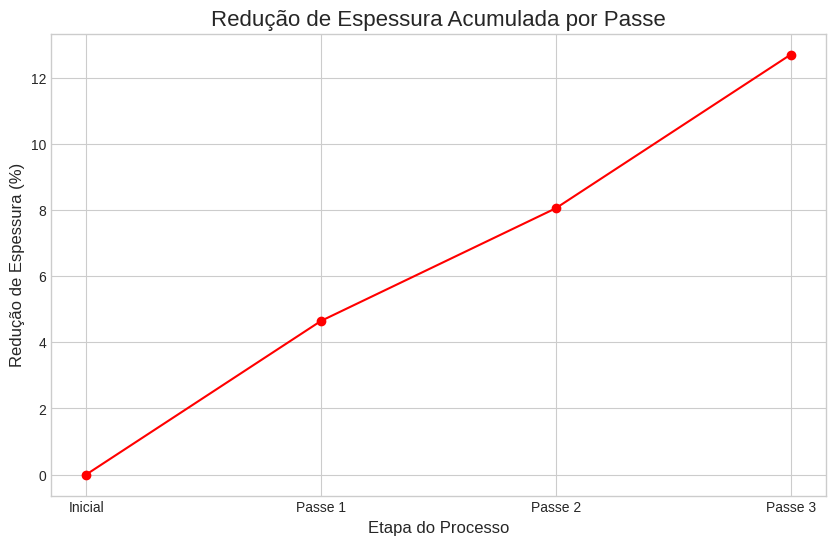

In [18]:
resultados_finais = []
e0, L0, c0 = dados['Inicial']['e'], dados['Inicial']['L'], dados['Inicial']['c']
volume_inicial = e0 * L0 * c0
espessura_anterior = e0

for etapa, medidas in dados.items():
  if etapa == 'Inicial':
    continue

  ef, Lf, cf = medidas['e'], medidas['L'], medidas['c']
  volume_final = ef * Lf * cf
  desvio_vol = ((volume_final - volume_inicial) / volume_inicial) * 100
  epsilon_e = math.log(ef / e0)
  epsilon_L = math.log(Lf / L0)
  epsilon_c = math.log(cf / c0)
  soma_epsilon = epsilon_e + epsilon_L + epsilon_c

  #Cálculos do Relatório
  var_e_percent = ((ef - e0) / e0) * 100
  delta_e_passe = espessura_anterior - ef

  h_medio = (espessura_anterior + ef) / 2
  L_contato = math.sqrt(R_rolo * delta_e_passe)
  termo_exp = (mu * L_contato) / h_medio
  pressao_laminacao = (h_medio / (mu * L_contato)) * (math.exp(termo_exp) - 1) * sigma_0

  largura_media_passe = (L0 + Lf) / 2
  largura_m = largura_media_passe / 1000
  L_contato_m = L_contato / 1000
  pressao_corrigida_Pa = pressao_laminacao * 1e6
  forca_N = pressao_corrigida_Pa * largura_m * L_contato_m
  velocidade_rpm = 50
  velocidade_chapa = 2*math.pi*(R_rolo/1000)*velocidade_rpm/60
  potencia_linear_W = forca_N * velocidade_chapa

  resultados_finais.append({'Etapa': etapa,
                            'Volume (mm³)': volume_final,
                            'Desvio Volumétrico (%)': desvio_vol,
                            'Redução Espessura (%)': abs(var_e_percent),
                            'ε_total': soma_epsilon,
                            'Pressão de Laminação (MPa)': pressao_laminacao,
                            'Força (kN)': forca_N / 1000,
                            'Potência (W)': potencia_linear_W})

  espessura_anterior = ef

df_final = pd.DataFrame(resultados_finais)
print(df_final.round(3).to_string(index=False))

plt.style.use('seaborn-v0_8-whitegrid')
ponto_inicial = pd.DataFrame([{'Etapa': 'Inicial', 'Redução Espessura (%)': 0}])
df_plot_reducao = pd.concat([ponto_inicial, df_final[['Etapa', 'Redução Espessura (%)']]], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot_reducao['Etapa'], df_plot_reducao['Redução Espessura (%)'], 'o-', color='red')
plt.title('Redução de Espessura Acumulada por Passe', fontsize=16)
plt.ylabel('Redução de Espessura (%)', fontsize=12)
plt.xlabel('Etapa do Processo', fontsize=12)
plt.show()

/tmp/ipython-input-1926231320.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


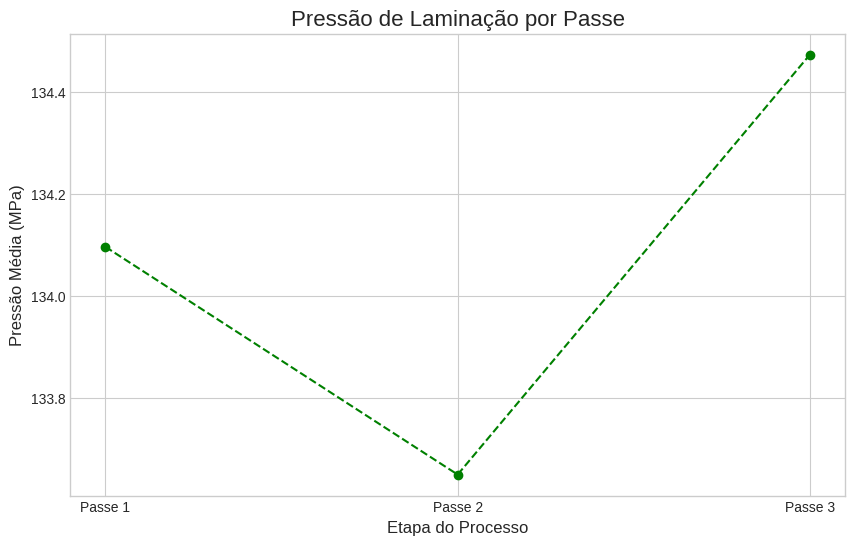

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df_final['Etapa'], df_final['Pressão de Laminação (MPa)'], 'o--', color='green')
plt.title('Pressão de Laminação por Passe', fontsize=16)
plt.xlabel('Etapa do Processo', fontsize=12)
plt.ylabel('Pressão Média (MPa)', fontsize=12)
plt.legend()
plt.show()

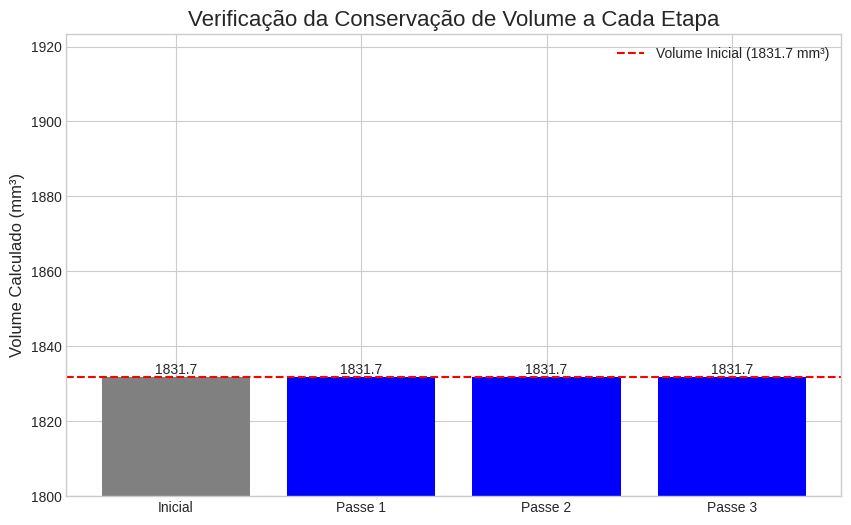

In [20]:
df_volume_plot = pd.concat([pd.DataFrame([{'Etapa': 'Inicial', 'Volume (mm³)': volume_inicial}]), df_final[['Etapa', 'Volume (mm³)']]], ignore_index=True)
plt.figure(figsize=(10, 6))
bars = plt.bar(df_volume_plot['Etapa'], df_volume_plot['Volume (mm³)'], color=['gray', 'blue', 'blue', 'blue'])
plt.axhline(y=volume_inicial, color='r', linestyle='--', label=f'Volume Inicial ({volume_inicial:.1f} mm³)')
plt.title('Verificação da Conservação de Volume a Cada Etapa', fontsize=16)
plt.ylabel('Volume Calculado (mm³)', fontsize=12)
plt.ylim(bottom=1800)
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}', va='bottom', ha='center')
plt.show()

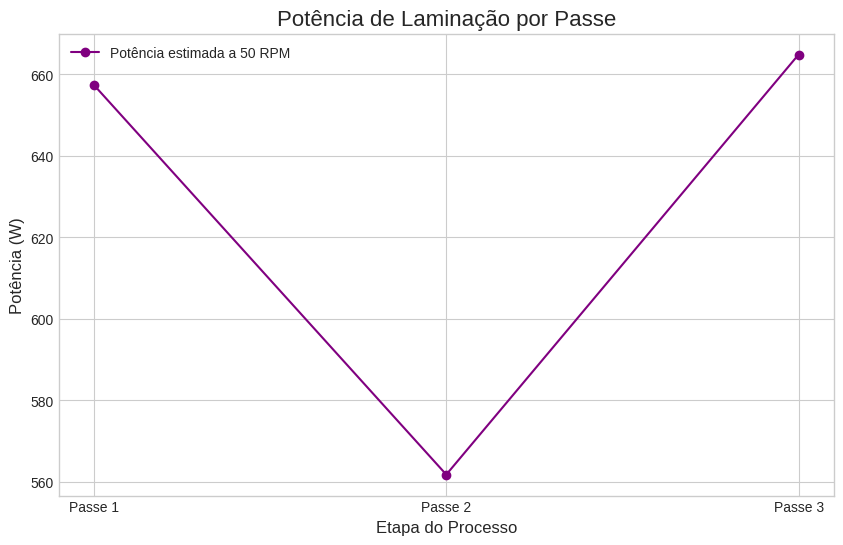

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df_final['Etapa'], df_final['Potência (W)'], 'o-', color='purple', label=f'Potência estimada a {velocidade_rpm} RPM')
plt.title('Potência de Laminação por Passe', fontsize=16)
plt.xlabel('Etapa do Processo', fontsize=12)
plt.ylabel('Potência (W)', fontsize=12)
plt.legend()
plt.show()

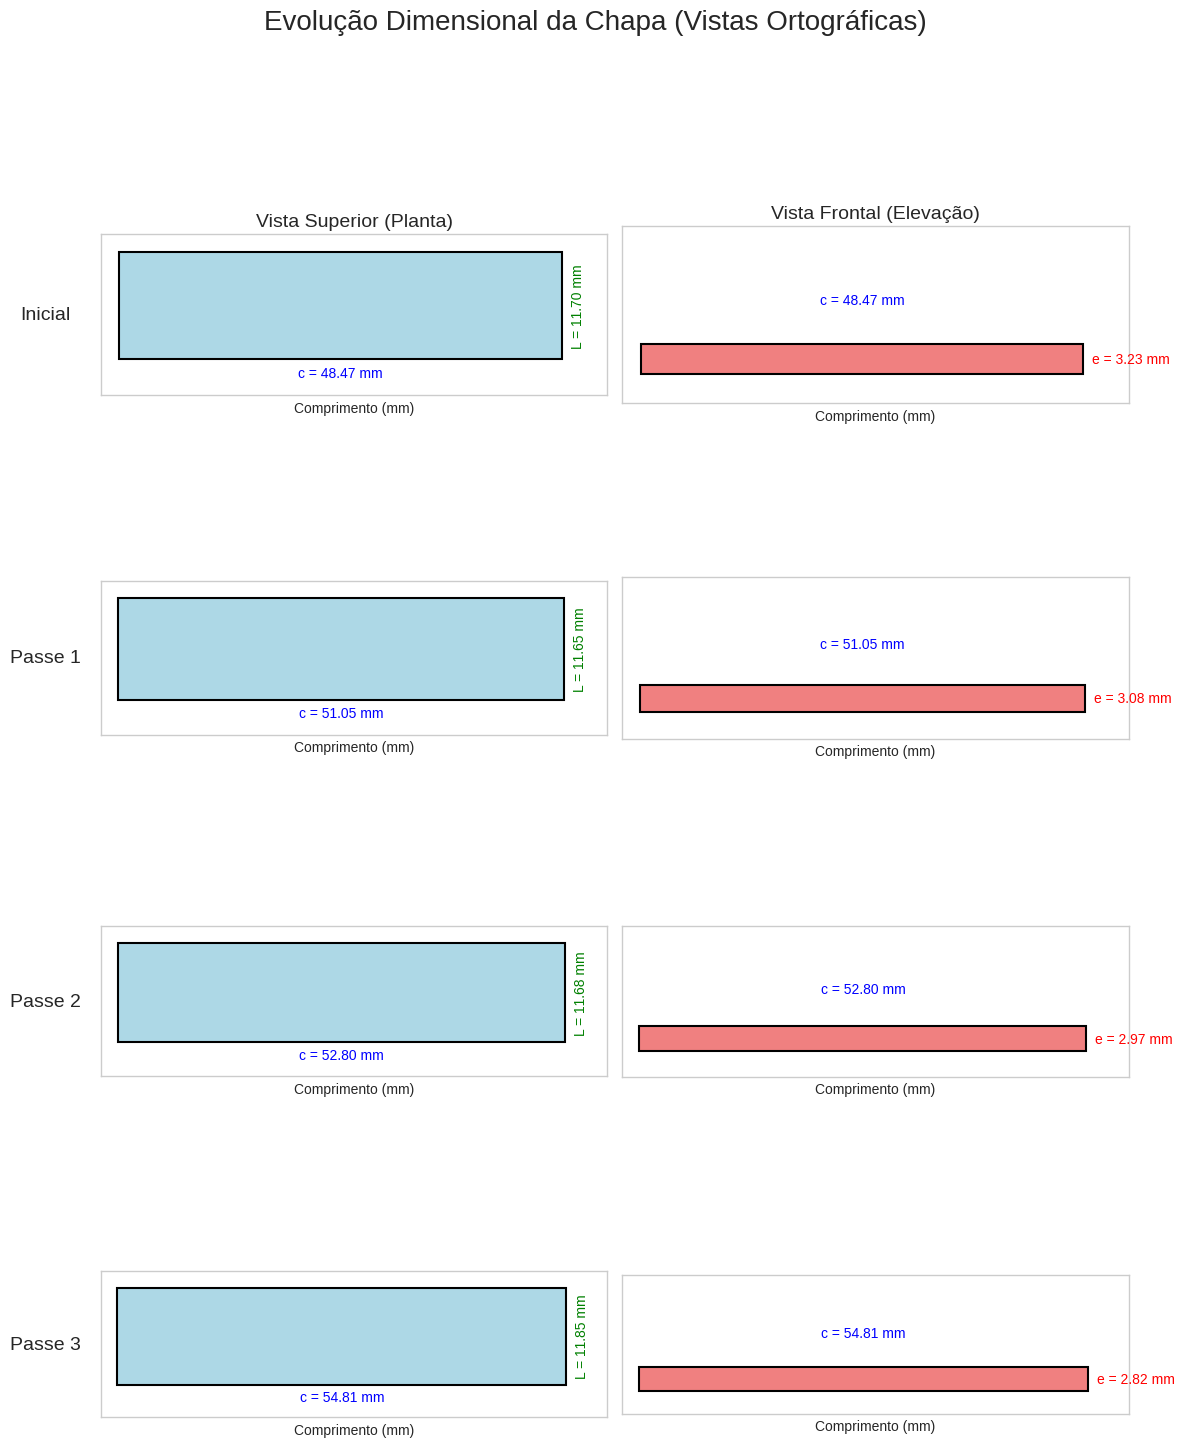

In [25]:
import matplotlib.patches as patches
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle('Evolução Dimensional da Chapa (Vistas Ortográficas)', fontsize=20)

axes[0, 0].set_title('Vista Superior (Planta)', fontsize=14)
axes[0, 1].set_title('Vista Frontal (Elevação)', fontsize=14)

for i, (etapa, dimensions) in enumerate(dados.items()):
  c, L, e = dimensions['c'], dimensions['L'], dimensions['e']
  ax1 = axes[i, 0]

  rect1 = patches.Rectangle((0, 0), c, L, linewidth=1.5, edgecolor='black', facecolor='lightblue')
  ax1.add_patch(rect1)
  ax1.text(c / 2, -1.5, f'c = {c:.2f} mm', ha='center', va='center', color='blue')
  ax1.text(c*1.02, L / 2, f'L = {L:.2f} mm', ha='left', va='center', color='green', rotation=90)

  ax1.set_xlim(-2, c + 5)
  ax1.set_ylim(-4, L + 2)
  ax1.set_aspect('equal', adjustable='box')
  ax1.set_xlabel('Comprimento (mm)')
  ax1.set_ylabel(etapa, fontsize=14, rotation=0, labelpad=40, va='center') # Label da linha
  ax1.grid(False)
  ax1.set_xticks([])
  ax1.set_yticks([])


  ax2 = axes[i, 1]
  rect2 = patches.Rectangle((0, 0), c, e, linewidth=1.5, edgecolor='black', facecolor='lightcoral')
  ax2.add_patch(rect2)
  ax2.text(c / 2, e*2.5, f'c = {c:.2f} mm', ha='center', va='center', color='blue')
  ax2.text(c*1.02, e / 2, f'e = {e:.2f} mm', ha='left', va='center', color='red')
  ax2.set_xlim(-2, c + 5)
  ax2.set_ylim(-e, e * 5)
  ax2.set_aspect('equal', adjustable='box')
  ax2.set_xlabel('Comprimento (mm)')
  ax2.grid(False)
  ax2.set_xticks([])
  ax2.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()